In [245]:
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import gc
from annoy import AnnoyIndex
import seaborn as sns
from textblob import TextBlob
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# FASTTEXT

In [3]:
file = open("testfile.txt", "w") 

In [4]:
for i in range(10000):
    file.write(train.loc[i].question1) 
    file.write(" ; ")
    file.write(train.loc[i].question2)

In [5]:
model = fasttext.train_unsupervised('testfile.txt', model='skipgram')

In [6]:
arr = []
for j in range(8):
    q1 = model.get_sentence_vector(train.loc[j].question1)
    question1 = train.loc[j].question1
    q2 = model.get_sentence_vector(train.loc[j].question2)
    question2 = train.loc[j].question2
    result = 1 - spatial.distance.cosine(q1, q2)
    d = {'q1': question1, 'q2': question2, 'result': result}
    arr.append(d)

In [8]:
df = pd.DataFrame(arr)
df

,q1,q2,result
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.993545
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.935992
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.959099
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.838952
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.972258
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",0.989445
6,Should I buy tiago?,What keeps childern active and far from phone ...,0.859001
7,How can I be a good geologist?,What should I do to be a great geologist?,0.946917


# ANNOY

In [284]:
l = 1000
f = model.get_sentence_vector(train.loc[1].question1).shape[0]
t = AnnoyIndex(f, 'angular')

In [285]:
train_copy = train.loc[:1000].copy()

def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

train_copy['question1'] = train_copy['question1'].apply(split_into_tokens)
train_copy['question2'] = train_copy['question2'].apply(split_into_tokens)

In [286]:
str(train_copy.loc[i].question1)

"[u'What', u'is', u'a', u'good', u'song', u'for', u'lyric', u'prank']"

In [287]:
for i in range(l):
    qid1 = train_copy.loc[i].qid1
    v = model.get_sentence_vector(str(train_copy.loc[i].question1))
    print(qid1, train_copy.loc[i].question1)
    t.add_item(qid1, v)

    qid2 = train_copy.loc[i].qid2
    v2 = model.get_sentence_vector(str(train_copy.loc[i].question2))
    print(qid2, train_copy.loc[i].question2)
    t.add_item(qid2, v2)

o', u'Apple', u'computers/laptops', u'have', u'over', u'other', u'brands']))
(1824, WordList([u'Why', u'do', u'so', u'many', u'people', u'in', u'the', u'US', u'have', u'an', u'Apple-branded', u'phone', u'or', u'laptop']))
(1825, WordList([u'What', u'is', u'the', u'first', u'moment', u'you', u'remember', u'in', u'your', u'Life']))
(1826, WordList([u'What', u'is', u'the', u'very', u'first', u'thing', u'you', u'remember', u'in', u'your', u'life']))
(1827, WordList([u'What', u'can', u'I', u'do', u'after', u'completing', u'BDS']))
(1828, WordList([u'What', u'can', u'we', u'do', u'after', u'completing', u'BDs']))
(1829, WordList([u'Does', u'all', u'Muslims', u'hate', u'Narendra', u'Modi']))
(1830, WordList([u'Why', u'Muslims', u'hate', u'Modi', u'government']))
(1831, WordList([u'I', u"'m", u'18', u'What', u'should', u'I', u'do']))
(1832, WordList([u'What', u'can', u'I', u'do', u'when', u'I', u"'m", u'18']))
(1833, WordList([u'What', u'are', u'some', u'really', u'good', u'and', u'famous', u'

In [288]:
t.build(1)

True

In [289]:
arr_dic = []
for k in range(l):
    a = t.get_nns_by_item(k+1, 3, include_distances=True)[0][1]
    b = t.get_nns_by_item(k+1, 3, include_distances=True)[1][1]
    a1 = t.get_nns_by_item(k+1, 3, include_distances=True)[0][2]
    b1 = t.get_nns_by_item(k+1, 3, include_distances=True)[1][2]
    dic = {"question": k+1, "a":a, "b":b, "a1":a1, "b1":b1}
    arr_dic.append(dic)

, [0.0, 0.4145631194114685, 0.45248037576675415])
([700, 1305, 370], [0.0, 0.5362053513526917, 0.615516722202301])
([701, 702, 1739], [0.0, 0.08942478150129318, 0.34745529294013977])
([702, 701, 1739], [0.0, 0.08942478150129318, 0.37546300888061523])
([703, 704, 1944], [0.0, 0.23308782279491425, 0.32111862301826477])
([704, 703, 1944], [0.0, 0.23308782279491425, 0.40619388222694397])
([705, 134, 1097], [0.0, 0.2491803616285324, 0.2961459755897522])
([706, 707, 710], [0.0, 0.0838104858994484, 0.08627098053693771])
([707, 710, 89], [0.0, 0.06430984288454056, 0.06752359867095947])
([708, 826, 767], [0.0, 0.4689425528049469, 0.49447453022003174])
([709, 1419, 1835], [0.0, 0.3848322629928589, 0.38718414306640625])
([710, 711, 707], [0.0, 0.05974286049604416, 0.06430984288454056])
([711, 710, 707], [0.0, 0.05974286049604416, 0.07338064163923264])
([712, 623, 1834], [0.0, 0.26521286368370056, 0.2986212372779846])
([713, 626, 415], [0.0, 0.25410333275794983, 0.2699574828147888])
([714, 98, 156

In [290]:
df_annoy = pd.DataFrame(arr_dic, columns=['question', 'a', 'b', 'a1', 'b1'])
df_annoy

,question,a,b,a1,b1
0,1,2,0.156489,1273,0.392075
1,2,1,0.156489,927,0.342293
2,3,1449,0.337970,1178,0.356241
3,4,1221,0.362530,1283,0.370653
4,5,6,0.412868,1184,0.414459
5,6,5,0.412868,157,0.422695
6,7,698,0.381306,1918,0.390305
7,8,666,0.453650,124,0.453880
8,9,1994,0.330568,245,0.332552
9,10,9,0.345372,1519,0.398996


In [298]:
def is_duplicate(x):
    if (x['question'] - x['a'] == 1) or (x['a'] - x['question'] == 1) :
        return 1
    else:
        return 0

In [299]:
df_annoy['is_duplicate'] = df_annoy.apply(is_duplicate, axis=1)

In [305]:
train

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [300]:
df_annoy[]

,question,a,b,a1,b1,is_duplicate
0,1,2,0.156489,1273,0.392075,1
1,2,1,0.156489,927,0.342293,1
2,3,1449,0.337970,1178,0.356241,0
3,4,1221,0.362530,1283,0.370653,0
4,5,6,0.412868,1184,0.414459,1
5,6,5,0.412868,157,0.422695,1
6,7,698,0.381306,1918,0.390305,0
7,8,666,0.453650,124,0.453880,0
8,9,1994,0.330568,245,0.332552,0
9,10,9,0.345372,1519,0.398996,1


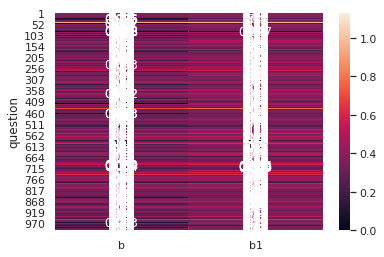

In [291]:
# df = pd.DataFrame(arr_dic, index=df_annoy['question'], columns=['b', 'b1'])
# sns.heatmap(df, annot=True)

In [279]:
train_copy

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",0
1,1,3,4,"[What, is, the, story, of, Kohinoor, Koh-i-Noo...","[What, would, happen, if, the, Indian, governm...",0
2,2,5,6,"[How, can, I, increase, the, speed, of, my, in...","[How, can, Internet, speed, be, increased, by,...",0
3,3,7,8,"[Why, am, I, mentally, very, lonely, How, can,...","[Find, the, remainder, when, math, 23, 24, mat...",0
4,4,9,10,"[Which, one, dissolve, in, water, quikly, suga...","[Which, fish, would, survive, in, salt, water]",0
5,5,11,12,"[Astrology, I, am, a, Capricorn, Sun, Cap, moo...","[I, 'm, a, triple, Capricorn, Sun, Moon, and, ...",1
6,6,13,14,"[Should, I, buy, tiago]","[What, keeps, childern, active, and, far, from...",0
7,7,15,16,"[How, can, I, be, a, good, geologist]","[What, should, I, do, to, be, a, great, geolog...",1
8,8,17,18,"[When, do, you, use, シ, instead, of, し]","[When, do, you, use, instead, of, and]",0
9,9,19,20,"[Motorola, company, Can, I, hack, my, Charter,...","[How, do, I, hack, Motorola, DCX3400, for, fre...",0
